In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
import csv
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import scipy
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [35]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.models import OriginalPlusMinimalAttentionDeep
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec, custom_collate_fn
from src.losses import calculate_metrics, improved_loss_progress
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple
complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")
stations_all = pandora_df["station"].unique()
station_color_map = dict(
    zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all))))
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Unique raw Pandora mask values: [0.0000000e+00 1.7004116e+15 1.7812890e+15 3.7569126e+15 3.7883480e+15
 4.3300999e+15 4.3411806e+15 7.2410223e+15 9.9955496e+15]


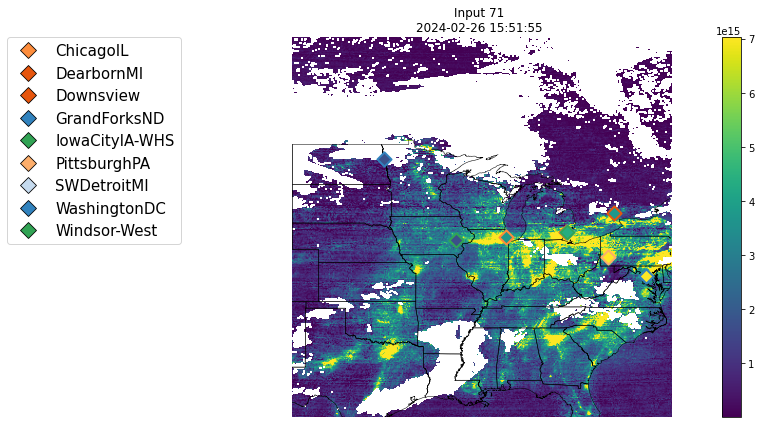

In [11]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min",
                n_blobs_range=(1, 5),
                sigma_xy_range=(5.0, 25.0),  # Spatial smoothing range
                thr_range=(0.3, 0.7),       # Threshold range for hole creation
                use_blob_gaps=True):
        
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # store and index files by timestamp
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)

        # sort by time (keep a parallel array of paths)
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        self.n_blobs_range = n_blobs_range
        self.sigma_xy_range = sigma_xy_range
        self.thr_range = thr_range
        self.use_blob_gaps = use_blob_gaps
        self.current_epoch = 0
        self.max_epochs = 1  # will be updated in training loop

        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

        
    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    
    def _make_2d_blob_mask(
        self, H, W, keep_mask_2d, rng,
        min_frac=0.05, max_frac=0.25,              # desired coverage bounds (0–1)
        n_blobs_range=(1, 4),                      # how many “clouds” to sum
        sigma_xy_range=(8, 30),                    # smoothing (pixels) for 400×400
        multiscale=True                            # add a second, coarser octave
    ):
        """
        Return a 2D keep mask [H,W] (1=keep, 0=artificial hole) whose hole
        coverage is <= max_frac *within* the originally valid TEMPO region.
        """
        # ----- 0) Nothing to do? -----
        n_blobs = int(rng.integers(n_blobs_range[0], n_blobs_range[1]+1))
        if n_blobs <= 0:
            return np.ones((H, W), dtype=np.float32)

        # ----- 1) Build a smooth “cloud” field -----
        field = np.zeros((H, W), dtype=np.float32)
        for _ in range(n_blobs):
            noise = rng.standard_normal((H, W)).astype(np.float32)
            sigma = float(rng.uniform(*sigma_xy_range))
            field += scipy.ndimage.gaussian_filter(noise, sigma=sigma, mode="nearest")

            if multiscale:
                # a coarser octave makes blobs more cloud-like
                noise2 = rng.standard_normal((H, W)).astype(np.float32)
                sigma2 = sigma * 1.8
                field += 0.6 * scipy.ndimage.gaussian_filter(noise2, sigma=sigma2, mode="nearest")

        # Normalize to [0,1]
        fmin, fmax = np.min(field), np.max(field)
        if fmax > fmin:
            field = (field - fmin) / (fmax - fmin)
        else:
            field = np.full((H, W), 0.5, dtype=np.float32)

        # ----- 2) Choose a target fraction and compute quantile threshold -----
        maskable = (keep_mask_2d.astype(bool))
        vals = field[maskable]
        if vals.size == 0:
            return np.ones((H, W), dtype=np.float32)

        target_frac = float(rng.uniform(min_frac, max_frac))  # variability per image
        # threshold so that ~target_frac of maskable pixels become holes
        thr = np.quantile(vals, 1.0 - target_frac)

        # Create holes & cap to max_frac (robust to numerical drift)
        holes = (field >= thr) & maskable
        # If we overshoot slightly, tighten threshold to max_frac
        if holes.mean() > max_frac:
            thr_cap = np.quantile(vals, 1.0 - max_frac)
            holes = (field >= thr_cap) & maskable

        # Convert to keep mask
        keep = np.ones((H, W), dtype=np.float32)
        keep[holes] = 0.0

        # Optional: soften edges a bit (looks more like clouds)
        # keep = scipy.ndimage.gaussian_filter(keep, sigma=0.8)
        # keep = (keep > 0.5).astype(np.float32)

        return keep
    def _make_progressive_mask(self, H, W, keep_mask_2d, rng, epoch, max_epochs):
        # compute progression factor
        frac = min(epoch / max_epochs, 1.0)  # goes 0 → 1
        # interpolate mask coverage
        max_cover = 0.25  # 25% max
        min_cover = 0.05  # 5% start
        cover_frac = min_cover + frac * (max_cover - min_cover)

        # call your _make_2d_blob_mask with threshold tuned to hit cover_frac
        keep = self._make_2d_blob_mask(H, W, keep_mask_2d, rng)
        # optionally re-balance threshold until keep.mean() ≈ 1 - cover_frac
        return keep
    
    def sample_vis(self, idx=None, train=None, shp_path='/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp', save=False):
        if idx is None:
            idx = np.random.randint(len(self))
        

        # Use the dataset's train flag if not explicitly provided
        if train is None:
            train = self.train

        sample = self[idx]

        print("Unique raw Pandora mask values:", np.unique(sample['p_val_mask']))

        # --- Convert Pandora values to usable numpy array ---
        p_val_map = sample.get("p_val_mask", None)
        if p_val_map is not None and torch.is_tensor(p_val_map):
            p_val_map = p_val_map.numpy().astype(np.float64)

            # Replace zeros with NaN (sparse representation)
            p_val_map[p_val_map == 0.0] = np.nan


        # --- DENORMALIZE IMAGES ---
        inp_np = sample["masked_img"][0].numpy()
        targ = sample['target'][0].numpy()
        if hasattr(self, "normalizer"):
            inp_np = self.normalizer.denormalize_image(inp_np)
            targ   = self.normalizer.denormalize_image(targ)

        known_mask = sample["known_mask"][0].numpy().astype(bool)
        p_mask = sample.get('p_mask', None)

        # Calculate vmin/vmax for consistent scaling on *denormalized* target
        vmin, vmax = np.percentile(targ[np.isfinite(targ)], [2, 98])
        cmap_v = plt.cm.viridis.copy()
        cmap_v.set_bad("white")

        # Get image metadata for Pandora plotting
        path = sample["path"]
        date_str = path.split('/')[-1].split('.')[0]
        date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

        # Get georeferencing info for Pandora
        with rasterio.open(path) as src:
            tr = src.transform
            crs = src.crs
            H, W = src.height, src.width

        ts = self._parse_time_from_fname(os.path.basename(path))
        xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

        # Load shapefile segments if provided
        segments = []
        segments = load_shapefile_segments_pyshp(shp_path, crs)

        from scipy.ndimage import distance_transform_edt

        from scipy.spatial import cKDTree

        def _add_shape_and_pandora(ax, plot_pandora=True):
            """Add shapefile and Pandora stations with station-colored outlines
            and Pandora-value fill colors matched to TEMPO colormap.
            """
            # Add shapefile
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))

            # Add Pandora stations if available
            if plot_pandora and hasattr(self, 'pandora_df') and self.pandora_df is not None and ts is not pd.NaT:
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()

                if not dfw.empty:
                    if "station" in dfw.columns:
                        dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                        dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                    # Color map for stations
                    stations_all = self.pandora_df["station"].unique()
                    color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

                    # Coordinates
                    lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

                    if ok_ll.sum() > 0:
                        dfw = dfw.loc[ok_ll].copy()
                        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
                        labels = dfw["station"].astype(str).to_numpy()

                        rr_i = rr.astype(int)
                        cc_i = cc.astype(int)
                        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
                        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

                        if rr_i.size > 0:
                            xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

                            # Normalize Pandora values to TEMPO colormap
                            norm = plt.Normalize(vmin=vmin, vmax=vmax)

                            p_val_arr = np.array(p_val_map, dtype=np.float64)

                            valid_mask = np.isfinite(p_val_arr)
                            valid_coords = np.argwhere(valid_mask)
                            valid_values = p_val_arr[valid_mask]


                            tree = cKDTree(valid_coords)

                            for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
                                outline_color = color_map.get(lab, "red")

                                # Query nearest valid Pandora pixel
                                dist, idx = tree.query([r, c])
                                nearest_row, nearest_col = valid_coords[idx]
                                pandora_val = valid_values[idx]

                                if np.isfinite(pandora_val):
                                    fill_color = cmap_v(norm(pandora_val))
                                else:
                                    fill_color = "red"

                                ax.scatter(
                                    x, y, s=100, marker='D',
                                    facecolor=fill_color,
                                    edgecolor=outline_color, linewidth=2.0,
                                    zorder=6
                                )

                            return True, color_map, labels

            return False, {}, []

        if train:
            # For training dataset, we have the realistic gaps
            realistic_gaps = sample['fake_mask'][0].numpy().astype(bool)
            all_masks = sample["known_and_fake_mask"][0].numpy().astype(bool)

            # SEPARATE THE GAPS: Extract only the gap pixels (not the original missing data)
            gaps_only_mask = known_mask & (~realistic_gaps)  # Areas that are known but made into gaps

            # Print statistics
            original_missing = (~known_mask).sum()
            gaps_only = gaps_only_mask.sum()
            all_artificial = (~realistic_gaps).sum()
            total_holes = (~all_masks).sum()
            gap_percentage = 100 * gaps_only / known_mask.sum()

            fig, ax = plt.subplots(1, 4, figsize=(26, 6))

            # Panel 1: Input (masked with all masks) + Pandora
            im0 = ax[0].imshow(np.ma.array(inp_np, mask=~all_masks), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[0].set_title(f"Input {idx} (all masks)\n{date}")
            ax[0].set_xlim(xmin, xmax)
            ax[0].set_ylim(ymin, ymax)
            ax[0].set_aspect('equal')
            fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 1
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax[0], plot_pandora=True)

            # Panel 3: GAPS ONLY (artificial holes in previously known areas)
            ax[1].imshow(gaps_only_mask, cmap="Blues", alpha=0.7)
            ax[1].set_title(f"Gaps Only {gap_percentage:.1f}%")

            # Panel 4: Combined mask (all holes)
            ax[2].imshow(all_masks == 0, cmap="gray", alpha=0.7)
            ax[2].set_title("All Masks Combined")

            # Panel 5: Original target + Pandora
            im4 = ax[3].imshow(np.ma.array(targ, mask=~np.isfinite(targ)),
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax[3].set_title(f"Original Target\n{date}")
            ax[3].set_xlim(xmin, xmax)
            ax[3].set_ylim(ymin, ymax)
            ax[3].set_aspect('equal')
            fig.colorbar(im4, ax=ax[3], fraction=0.046, pad=0.04)

            # Add shapefile and Pandora to panel 5
            _add_shape_and_pandora(ax[3], plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.5,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=15, markerscale=1.2)

            for a in ax[1:4]:  # Skip panels with geographic coords
                a.axis("off")

            plt.tight_layout()
            plt.show()

        else:
            fig, ax = plt.subplots(1, 1, figsize=(18, 6))

            # Panel 1: Input (masked with known mask only) + Pandora
            im0 = ax.imshow(np.ma.array(inp_np, mask=~known_mask), 
                              cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
            ax.set_title(f"Input {idx} \n{date} ")
#             ax[0].set_title(f"Input {idx} \n{date} ")
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            ax.set_aspect('equal')
            fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)
            has_pandora, color_map, station_labels = _add_shape_and_pandora(ax, plot_pandora=True)

            # Add legend if Pandora stations were plotted
            if has_pandora and len(station_labels) > 0:
                legend_handles = []
                for lab in np.unique(station_labels):
                    c = color_map.get(lab, "red")
                    proxy = Line2D([0], [0], marker='D', color='none',
                                 markerfacecolor=c, markeredgecolor='k', markeredgewidth=0.8,
                                 markersize=9, label=lab)
                    legend_handles.append(proxy)

                ax.legend(handles=legend_handles, bbox_to_anchor=(-0.75, 1),
                            loc="upper left", borderaxespad=0., frameon=True,
                            fontsize=15, markerscale=1.2)

            ax.axis("off")  # Only turn off axis for the middle panel

            plt.tight_layout()
#             plt.savefig(f"sample_vis_{idx}.png", dpi=300, bbox_inches="tight", facecolor='white')
            plt.show()


    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 


        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()

                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # Get station names for valid coordinates - FIXED VERSION
                dfw_ok = dfw.loc[ok].reset_index(drop=True)  # Filter dataframe to match valid coordinates
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): 
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): 
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: 
                    vals_n = vals.astype(np.float32)  # identity

                # Store Pandora data and station names
                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))

                    # Add corresponding station name
                    if i < len(station_names_raw):
                        station_names.append(station_names_raw[i])
                    else:
                        station_names.append(f"Unknown_{i}")

                val_list = vals_n.tolist()

        if self.train:
            if self.use_blob_gaps:
                # Use cloud-like blob gaps
                rng = np.random.default_rng()
                realistic_gaps = self._make_progressive_mask(H,W,known_mask, rng, 
                                                   epoch=self.current_epoch, max_epochs = self.max_epochs)
#                 realistic_gaps = self._make_2d_blob_mask(H, W, known_mask, rng)
            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,  # Add station names to sample
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),         
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),       
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),          
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  
                "path": path,
            }
            return sample

        else:
            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,  # Add station names to sample
                "masked_img": torch.from_numpy(img_n).unsqueeze(0).float(),         
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),            
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),                  
                "path": path
            }

            return sample
train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df,
                                        n_blobs_range=(1, 3),
                                        sigma_xy_range=(8, 30),  # Very large smoothing
                                        thr_range=(0.3, 0.5), use_blob_gaps=True)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)
val_ds.sample_vis(train=False, save = False)


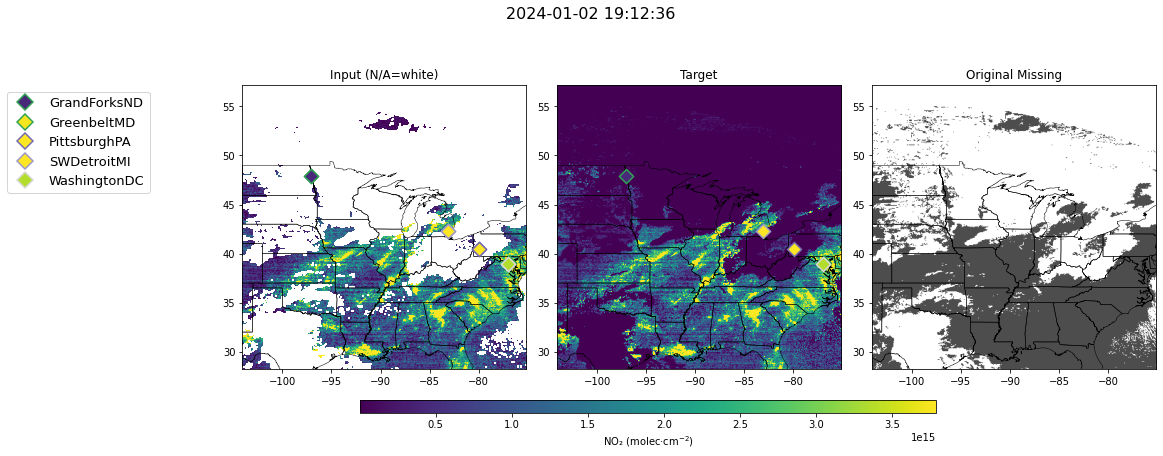

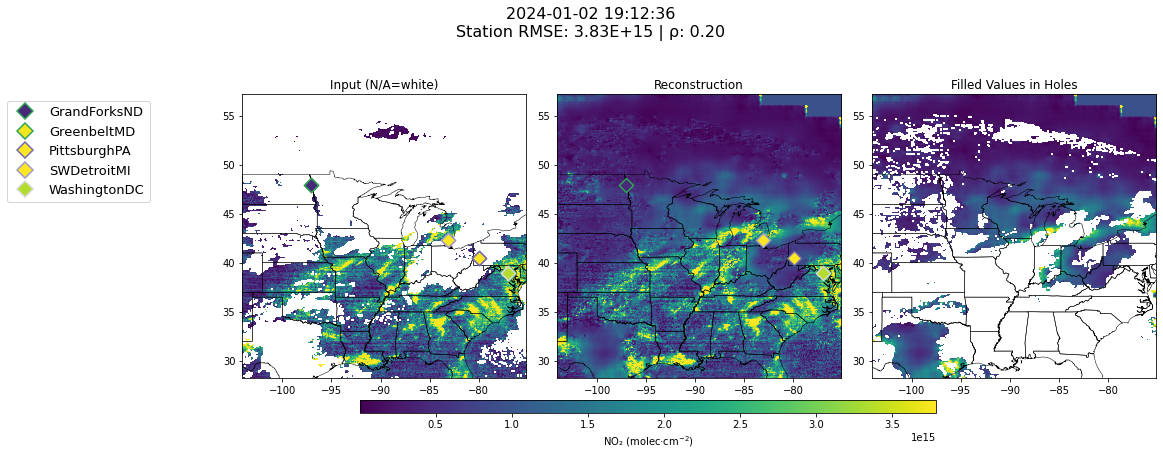

In [41]:
def visualize_sample_or_batch(
    sample=None,
    dataloader=None,
    batch_idx=0,
    sample_idx=0,
    model=None,
    normalizer=None,
    device="cuda",
    train=True,
    inference=False,
    shp_path=None,
    pandora_df=None,
    save=False,
    save_path=None,
    time_tolerance="30min",
    station_color_map = station_color_map
):
    """
    Unified visualization for dataset samples (training/validation) and inference batches,
    with Pandora station overlays (consistent global colors + per-station RMSE).
    """

    # --------------------------------------------------
    # --- 1. Get sample (from dataset or dataloader)
    # --------------------------------------------------
    if sample is None and dataloader is not None:
        try:
            for i, batch in enumerate(dataloader):
                if i == batch_idx:
                    break
            else:
                print(f"Batch index {batch_idx} not found")
                return
        except Exception as e:
            print(f"Error getting batch: {e}")
            return

        batch_size = batch["masked_img"].shape[0]
        if sample_idx >= batch_size:
            print(f"Sample idx {sample_idx} not available, using 0")
            sample_idx = 0

        sample = {}
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                sample[key] = value[sample_idx]
            elif isinstance(value, (list, tuple)):
                sample[key] = value[sample_idx]
            else:
                sample[key] = value

    if sample is None:
        raise ValueError("Must provide either `sample` or `dataloader`.")

    # --------------------------------------------------
    # --- 2. Pandora map conversion
    # --------------------------------------------------
    p_val_map = sample.get("p_val_mask", None)
    if p_val_map is not None and torch.is_tensor(p_val_map):
        p_val_map = p_val_map.numpy().astype(np.float64)
        p_val_map[p_val_map == 0.0] = np.nan

    known_mask = sample["known_mask"][0].numpy().astype(bool) if sample["known_mask"].ndim == 3 else sample["known_mask"].numpy().astype(bool)

    # --------------------------------------------------
    # --- 3. Denormalize / Inputs
    # --------------------------------------------------
    inp_np = sample["masked_img"][0].numpy()
    targ = sample["target"][0].numpy()
    if hasattr(normalizer, "denormalize_image"):
        inp_np = normalizer.denormalize_image(inp_np)
        targ   = normalizer.denormalize_image(targ)

    # --------------------------------------------------
    # --- 4. Inference if flagged
    # --------------------------------------------------
    pred_np_final = None
    pandora_rmse = None
    pandora_rho  = None

    if inference and model is not None:
        model.eval()
        img = sample["masked_img"].unsqueeze(0).to(device)
        mask_obs = sample["known_mask"].unsqueeze(0).to(device)
        target = sample["target"].unsqueeze(0).to(device)

        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device) if train else mask_obs

        with torch.no_grad():
            pred, _ = model(img, mask)

        pred_np = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
        pred_np_final = pred_np.copy()
        pred_np_final[~mask[0,0].cpu().numpy().astype(bool)] = pred_np[~mask[0,0].cpu().numpy().astype(bool)]

        # Pandora RMSE/ρ
        p_mask = sample.get("p_mask", torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
        if p_mask.any():
            pandora_rows, pandora_cols = np.where(p_mask)
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            if hasattr(normalizer, "denormalize_pandora_array"):
                pandora_values = normalizer.denormalize_pandora_array(pandora_values)

            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                from scipy import stats
                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)

    # --------------------------------------------------
    # --- 5. Metadata + shapefile
    # --------------------------------------------------
    path = sample["path"]
    date_str = path.split("/")[-1].split(".")[0]
    date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width

    ts = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    segments = load_shapefile_segments_pyshp(shp_path, crs) if shp_path else []

    # --------------------------------------------------
    # --- 6. Colormap + vmin/vmax
    # --------------------------------------------------
    finite_vals = targ[np.isfinite(targ)]
    vmin, vmax = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (0.0, 1.0)
    cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

    # --------------------------------------------------
    # --- 7. Pandora plotting helper (GLOBAL COLORS)
    # --------------------------------------------------
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                              pandora_df, station_color_map, add_legend=False, pred_np_final=None):
        legend_handles = []
        if pandora_df is None or ts is pd.NaT:
            return legend_handles

        # Filter stations near this timestamp
        dfw = pandora_df[
            (pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
            (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))
        ].copy()

        if dfw.empty:
            return legend_handles

        # One record per station
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

        # Coordinates
        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)
        if ok_ll.sum() == 0:
            return legend_handles

        dfw = dfw.loc[ok_ll].copy()
        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i = rr.astype(int)
        cc_i = cc.astype(int)
        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

        if rr_i.size == 0:
            return legend_handles

        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        # Normalize values
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Build KD-tree of valid Pandora pixels
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr == 0.0] = np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask):
            return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        from scipy.spatial import cKDTree
        tree = cKDTree(valid_coords)

        # Loop stations
        for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
            outline_color = station_color_map.get(lab, "red")  # ✅ use global map

            # Nearest Pandora pixel
            dist, idx = tree.query([r, c])
            pandora_val = valid_values[idx]

            if np.isfinite(pandora_val):
                fill_color = cmap_v(norm(pandora_val))
            else:
                fill_color = "black"

            ax.scatter(
                x, y, s=100, marker='D',
                facecolor=fill_color,
                edgecolor=outline_color, linewidth=1.5,
                zorder=6
            )

            # Legend proxy
            if add_legend:
                rmse_str = ""
                if inference and pred_np_final is not None and np.isfinite(pandora_val):
                    pred_val = pred_np_final[r, c]
                    if np.isfinite(pred_val):
                        rmse = np.sqrt((pandora_val - pred_val) ** 2)
                        rmse_str = f"\nRMSE={rmse:.2E}"
                        
                proxy = Line2D(
                    [0], [0], marker="D", color="none",
                    markerfacecolor=fill_color,
                    markeredgecolor=outline_color, markeredgewidth=1.5,
                    markersize=9, label=lab
                )
                legend_handles.append(proxy)

        return legend_handles

    def add_pandora_stations(ax, add_legend=False):
        return _add_pandora_stations(
            ax=ax,
            tr=tr, crs=crs, H=H, W=W, ts=ts,
            p_val_map=p_val_map,
            vmin=vmin, vmax=vmax, cmap_v=cmap_v,
            pandora_df=pandora_df,
            station_color_map=station_color_map,
            add_legend=add_legend,
            pred_np_final=pred_np_final
        )

    # --------------------------------------------------
    # --- 8. Plotting panels
    # --------------------------------------------------
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))

    # Input
    disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~known_mask))
    im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title("Input (N/A=white)")
    ax[0].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    legend_handles = add_pandora_stations(ax[0], add_legend=True)
    # Reconstruction or Target
    if inference and pred_np_final is not None:
        # ✅ Use the reconstruction, not the target
        disp_recon = np.ma.masked_invalid(pred_np_final)
        im1 = rio_show(disp_recon, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Reconstruction")
    else:
        # Target (dataset visualization mode)
        im1 = ax[1].imshow(np.ma.array(targ, mask=~np.isfinite(targ)), cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Target")

    # Add shapefile overlay
    ax[1].add_collection(LineCollection(segments, colors="k", linewidths=0.5))

    # Filled values or Missing mask
    if inference and pred_np_final is not None:
        filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
        filled_only[~known_mask] = pred_np_final[~known_mask]
        ax[2].imshow(filled_only, cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Filled Values in Holes")
    else:
        ax[2].imshow(known_mask == 0, cmap="gray", alpha=0.7, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Original Missing")

    # Pandora stations + legend
    legend_handles = add_pandora_stations(ax[0], add_legend=True)
    if legend_handles:
        ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.85, 1), loc="upper left",
                     frameon=True, fontsize=13, markerscale=1.3)

    # Single colorbar
    cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.03]) # [left, bottom, width, height] in figure coords
    fig.colorbar(ax[1].images[0], cax=cbar_ax, orientation="horizontal").set_label("NO₂ (molec·cm$^{-2}$)")

    plt.suptitle(
        f"{date}" +
        (f"\nStation RMSE: {pandora_rmse:.2E} | ρ: {pandora_rho:.2f}" if inference and pandora_rmse else ""),
        fontsize=16
    )
    plt.tight_layout()

    if save and save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

sample = val_ds[0]
visualize_sample_or_batch(
    sample=sample,
    normalizer=val_ds.normalizer,
    shp_path=shp_path,
    pandora_df=val_ds.pandora_df,
    train=val_ds.train,
    inference=False,  # dataset-style
    station_color_map=station_color_map
)
visualize_sample_or_batch(
    dataloader=val_loader,
    batch_idx=0, sample_idx=0,
    model=model,
    normalizer=normalizer,
    device="cuda",
    shp_path=shp_path,
    pandora_df=pandora_df,
    inference=True,   # model + stats
    train=False,
    station_color_map=station_color_map
)


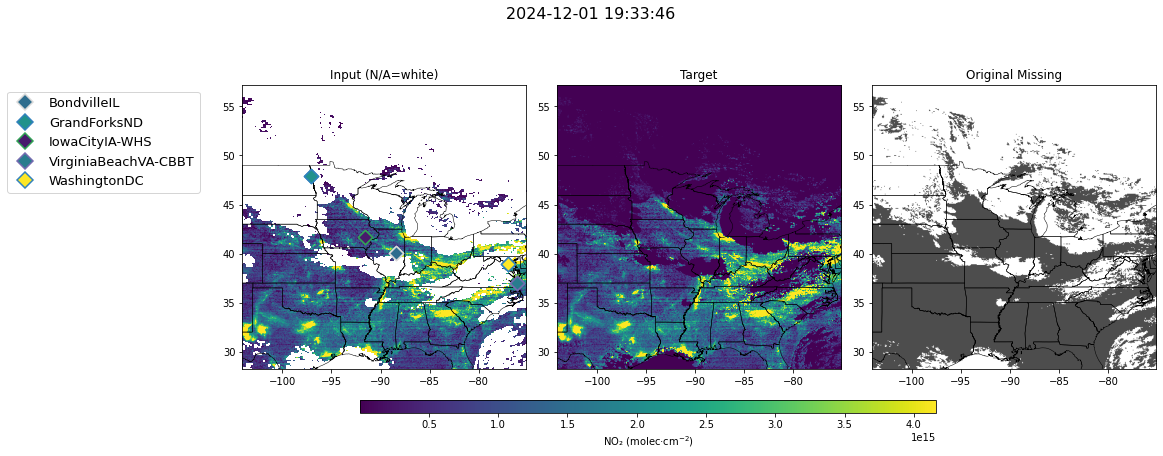

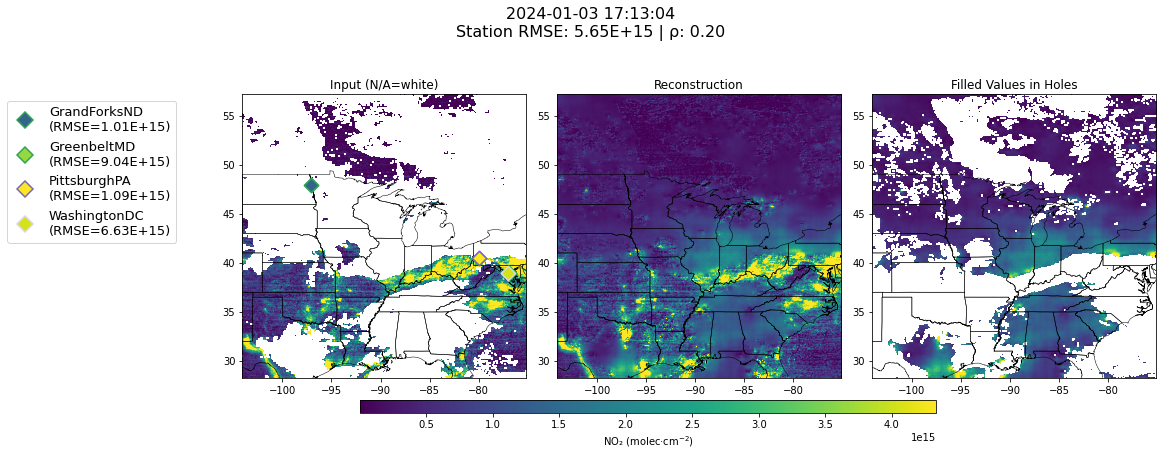

In [34]:
sample = val_ds[550]
visualize_sample_or_batch(
    sample=sample,
    normalizer=val_ds.normalizer,
    shp_path=shp_path,
    pandora_df=val_ds.pandora_df,
    train=val_ds.train,
    inference=False  # dataset-style
)
visualize_sample_or_batch(
    dataloader=val_loader,
    batch_idx=0, sample_idx=1,
    model=model,
    normalizer=normalizer,
    device="cuda",
    shp_path=shp_path,
    pandora_df=pandora_df,
    inference=True,   # model + stats
    train=False
)


In [ ]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import stats

def eval_pandora_metrics(model, normalizer, dataloader, device="cuda"):
    """
    Iterate over dataloader, compute Pandora RMSE and Spearman rho for each sample.
    Returns list of dicts with metrics for each sample.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch in dataloader:
            B = batch["masked_img"].shape[0]
            for b in range(B):
                # Extract single sample
                img = batch["masked_img"][b:b+1].to(device)       # [1,1,H,W]
                target = batch["target"][b:b+1].to(device)
                mask_obs = batch["known_mask"][b:b+1].to(device)

                if "known_and_fake_mask" in batch:
                    mask = batch["known_and_fake_mask"][b:b+1].to(device)
                else:
                    mask = mask_obs

                # Model prediction
                pred, _ = model(img, mask)

                # Denormalize
                pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
                tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())

                # Smooth prediction
                pred_np = gaussian_filter(pred_np, sigma=0.5)

                # Pandora data
                p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
                p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

                pandora_rmse, pandora_rho, n_pandora = None, None, 0
                if p_mask.any():
                    rows, cols = np.where(p_mask)
                    if len(rows) > 0:
                        pandora_values = p_val_map[rows, cols]

                        # Denormalize Pandora if possible
                        if hasattr(normalizer, 'denormalize_pandora_array'):
                            pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                        elif hasattr(normalizer, 'denormalize_pandora'):
                            pandora_values = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])

                        pred_at_pandora = pred_np[rows, cols]

                        valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
                        if valid_mask.sum() > 0:
                            pandora_valid = pandora_values[valid_mask]
                            pred_valid = pred_at_pandora[valid_mask]

                            pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                            if len(pandora_valid) > 1:
                                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                            n_pandora = len(pandora_valid)

                results.append({
                    "rho": pandora_rho,
                    "rmse": pandora_rmse,
                    "n_pandora": n_pandora
                })

    return results
metrics = eval_pandora_metrics(model, normalizer, val_loader, device="cuda")

# For example, aggregate results
all_rhos  = [m["rho"] for m in metrics if m["rho"] is not None]
all_rmses = [m["rmse"] for m in metrics if m["rmse"] is not None]

print(f"Avg rho:  {np.nanmean(all_rhos):.3f}")
print(f"Avg RMSE: {np.nanmean(all_rmses):.4E}")


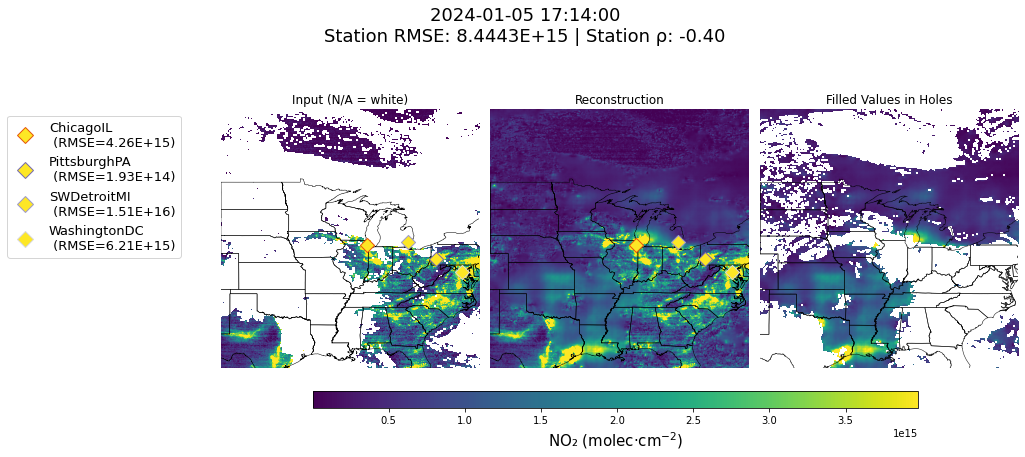

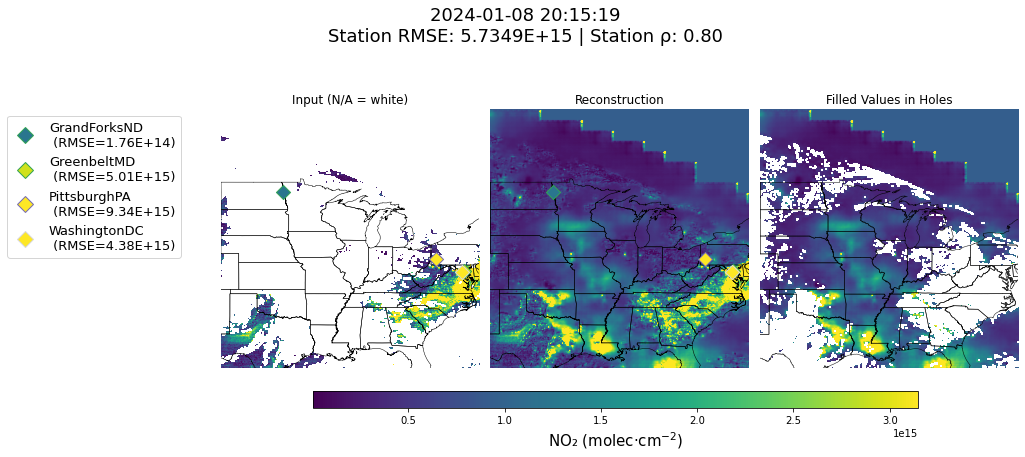

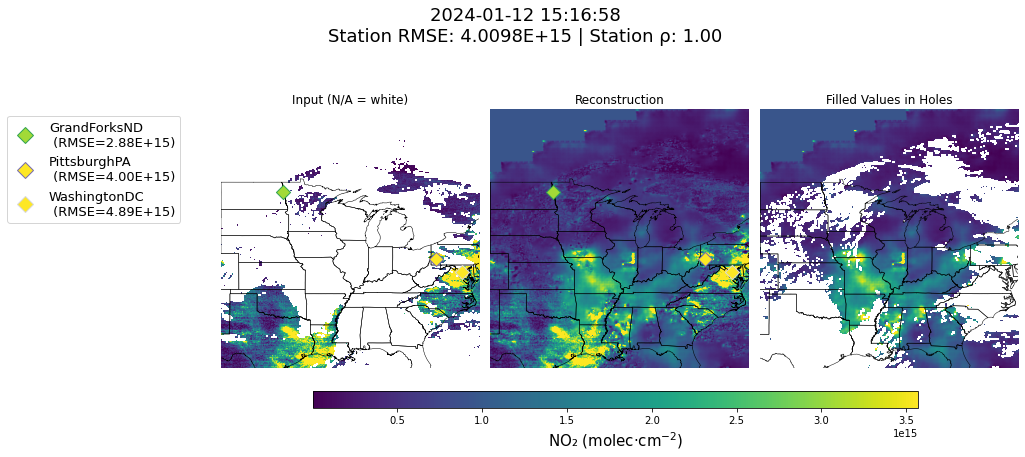

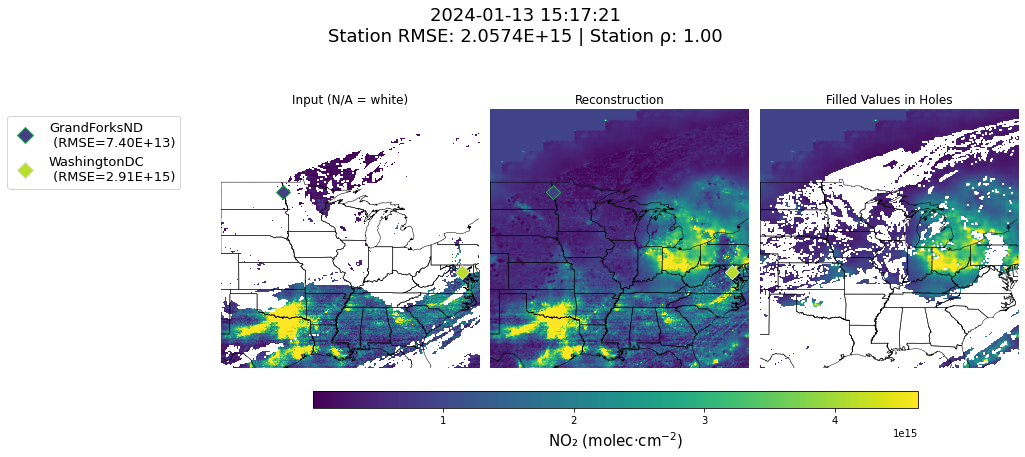

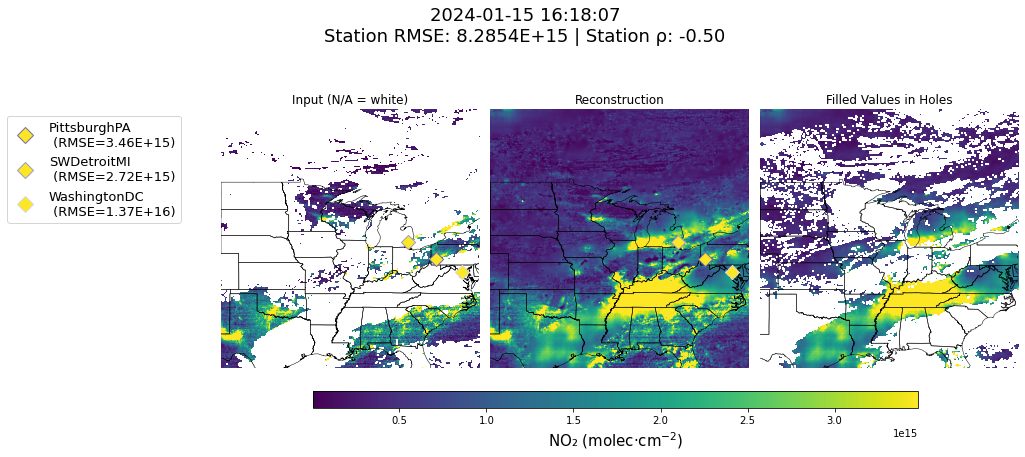

In [10]:
def _add_shape_pixel(ax, segments, tr, alpha=0.8, color="k"):
    """Add shapefile to pixel-coordinate panels"""
    if segments:
        segments_pixel = []
        for seg in segments:
            if len(seg) > 0:
                pixel_coords = []
                for x_geo, y_geo in seg:
                    col, row = ~tr * (x_geo, y_geo)
                    pixel_coords.append([col, row])
                segments_pixel.append(np.array(pixel_coords))
        ax.add_collection(LineCollection(segments_pixel, colors=color, linewidths=0.6, zorder=6, alpha=alpha))
        


        
def visualize_batch(epoch, model, normalizer, dataloader, batch_idx=0, sample_idx=0,
                    device="cuda", save=False, train=True, shp_path=shp_path, avg_thr=0.2,
                    pandora_df=pandora_df):
    """
    Visualize model predictions from a DataLoader following the dataset's pandora setup,
    with Pandora station plotting (consistent colors + per-station RMSE).
    """
    model.eval()

    # --- Get a batch ---
    try:
        for i, batch in enumerate(dataloader):
            if i == batch_idx:
                break
        else:
            print(f"Batch index {batch_idx} not found in dataloader")
            return
    except Exception as e:
        print(f"Error getting batch from dataloader: {e}")
        return

    # --- Extract sample ---
    batch_size = batch["masked_img"].shape[0]
    if sample_idx >= batch_size:
        print(f"Sample index {sample_idx} not available in batch of size {batch_size}")
        sample_idx = 0
        print(f"Using sample index {sample_idx} instead")

    sample = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            sample[key] = value[sample_idx]
        elif isinstance(value, (list, tuple)):
            sample[key] = value[sample_idx]
        else:
            sample[key] = value

    # --- Pandora data ---
    p_mask = sample.get('p_mask', torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    p_val_map = sample.get('p_val_mask', torch.zeros_like(sample["known_mask"])).numpy()

    # --- Inputs ---
    img = sample["masked_img"].unsqueeze(0).to(device)
    mask_obs = sample["known_mask"].unsqueeze(0).to(device)
    target = sample["target"].unsqueeze(0).to(device)

    if train:
        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device)
    else:
        mask = mask_obs

    # --- Prediction ---
    with torch.no_grad():
        pred, out_mask = model(img, mask)

    inp_np = normalizer.denormalize_image(img[0,0].cpu().numpy())
    mask_obs_np = mask_obs[0,0].cpu().numpy().astype(bool)
    pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
    tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())

    from scipy.ndimage import gaussian_filter
    pred_np = gaussian_filter(pred_np, sigma=0.5)

    if train:
        mask_np = sample["known_and_fake_mask"][0].cpu().numpy().astype(bool)
    else:
        mask_np = mask_obs_np

    hole_mask = ~mask_np
    pred_np_final = pred_np.copy()
    pred_np_final[hole_mask] = pred_np[hole_mask]

    # --- Metadata ---
    path = sample["path"]
    date = path.split('/')[-1].split('.')[0]
    date = datetime.strptime(date, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width

    ts = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)

    segments = []
    segments = load_shapefile_segments_pyshp(shp_path, crs)
    
    pandora_rmse = None
    pandora_rho = None
    n_pandora_stations = 0
    
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        if len(pandora_rows) > 0:
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            
            # Denormalize Pandora values if possible
            if hasattr(normalizer, 'denormalize_pandora'):
                pandora_values_denorm = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])
            elif hasattr(normalizer, 'denormalize_pandora_array'):
                pandora_values_denorm = normalizer.denormalize_pandora_array(pandora_values)
            else:
                pandora_values_denorm = pandora_values
            
            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            
            valid_mask = np.isfinite(pandora_values_denorm) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values_denorm[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                if len(pandora_valid) > 1:
                    from scipy import stats
                    pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                n_pandora_stations = len(pandora_valid)

    # --- Colormap ---
    finite_vals = tgt_np[np.isfinite(tgt_np)]
    if finite_vals.size:
        vmin, vmax = np.percentile(finite_vals, [2, 98])
    else:
        vmin, vmax = 0.0, 1.0

    cmap_v = plt.cm.viridis.copy()
    cmap_v.set_bad(color="white")
    
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                         pandora_df=pandora_df, add_legend=False, pred_np_final=None):

        legend_handles = []
        if pandora_df is None or ts is pd.NaT:
            return legend_handles

        # Filter stations near this timestamp
        dfw = pandora_df[
            (pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
            (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))
        ].copy()

        if dfw.empty:
            return legend_handles

        # Pick closest record per station
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

        # --- Global station colormap ---
        stations_all = pandora_df["station"].unique()
        color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

        # Coordinates
        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)

        if ok_ll.sum() == 0:
            return legend_handles

        dfw = dfw.loc[ok_ll].copy()
        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i = rr.astype(int)
        cc_i = cc.astype(int)
        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

        if rr_i.size == 0:
            return legend_handles

        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        # Normalize values
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Build KD-tree of valid Pandora pixels
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr == 0.0] = np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask):
            return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        from scipy.spatial import cKDTree
        tree = cKDTree(valid_coords)

        # Loop stations
        for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
            outline_color = color_map.get(lab, "red")

            # Nearest Pandora pixel
            dist, idx = tree.query([r, c])
            pandora_val = valid_values[idx]

            # Fill color
            if np.isfinite(pandora_val):
                fill_color = cmap_v(norm(pandora_val))
            else:
                fill_color = "black"

            ax.scatter(
                x, y, s=100, marker='D',
                facecolor=fill_color,
                edgecolor=outline_color, linewidth=1.0,
                zorder=6
            )

            # Per-station RMSE
            rmse_str = ""
            if pred_np_final is not None and np.isfinite(pandora_val):
                pred_val = pred_np_final[r, c]
                if np.isfinite(pred_val):
                    rmse = np.sqrt((pandora_val - pred_val) ** 2)
                    rmse_str = f" (RMSE={rmse:.2E})"

            # Legend proxy
            if add_legend:
                proxy = Line2D(
                    [0], [0], marker="D", color="none",
                    markerfacecolor=fill_color, markeredgecolor=outline_color, markeredgewidth=1,
                    markersize=9, label=f"{lab}\n{rmse_str}"
                )
                legend_handles.append(proxy)

        return legend_handles

    def add_pandora_stations(ax, add_legend=False):
        """Add Pandora stations from pandora_df with global colors + per-station RMSE."""
        return _add_pandora_stations(
            ax=ax, tr=tr, crs=crs, H=H, W=W, ts=ts,
            p_val_map=p_val_map, vmin=vmin, vmax=vmax, cmap_v=cmap_v,
            pandora_df=pandora_df, add_legend=add_legend, pred_np_final=pred_np_final
        )

    fig, ax = plt.subplots(1, 3, figsize=(14, 6))

    disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~mask_obs_np))
    im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].margins(0); ax[0].autoscale(False)
    ax[0].set_title(f"Input (N/A = white)")
    ax[0].axis("off")
    ax[0].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
    legend_handles = add_pandora_stations(ax[0], add_legend=True)

    disp_pred = np.ma.masked_invalid(pred_np_final)
    im1 = rio_show(disp_pred, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[1].set_xlim(xmin, xmax); ax[1].set_ylim(ymin, ymax)
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].margins(0); ax[1].autoscale(False)
    ax[1].set_title("Reconstruction")
    ax[1].axis("off")
    ax[1].add_collection(LineCollection(segments, colors='k', linewidths=0.5, zorder=3))
    add_pandora_stations(ax[1])        

    filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
    filled_only[~mask_obs_np] = pred_np_final[~mask_obs_np]
    ax[2].imshow(np.ma.array(filled_only, mask=np.isnan(filled_only)), cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[2].set_title("Filled Values in Holes")
    ax[2].axis("off")
    _add_shape_pixel(ax[2], segments, tr)

    if legend_handles:
        ax[0].legend(
            handles=legend_handles,
            bbox_to_anchor=(-0.85, 1),
            loc="upper left",
            frameon=True, fontsize=13, markerscale=1.3
        )
    cbar_ax = fig.add_axes([0.29, 0.05, 0.6, 0.04])  # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(im1.get_images()[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15)


    plt.suptitle(f"{date}\nStation RMSE: {pandora_rmse:.4E} | Station ρ: {pandora_rho:.2f}", fontsize=18)
    plt.tight_layout()
    plt.show()
    
    plt.close()
    
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

val_loader = DataLoader(
    val_ds, 
    batch_size=4, 
    shuffle=False,
    collate_fn=custom_collate_fn  # Add this line
)
model = OriginalPlusMinimalAttentionDeep(base_ch=32).cuda()  # Your original + tiny attention
model.load_state_dict(torch.load('/hpc/home/srs108/final_model.pt'))
for i in range(5):
    visualize_batch(epoch=5, model=model, normalizer=normalizer, dataloader=val_loader,
                        batch_idx=i, sample_idx=3, device="cuda", save=True, train=False, shp_path=shp_path)
    

In [4]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=1, base_ch=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1), nn.BatchNorm2d(base_ch*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1), nn.BatchNorm2d(base_ch*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(base_ch*4, 1, 4, padding=1)  # Patch map output
        )
    def forward(self, x):
        return self.model(x)

def d_loss(d_real, d_fake): return 0.5 * (torch.mean((d_real - 1)**2) + torch.mean(d_fake**2))
def g_adv_loss(d_fake): return torch.mean((d_fake - 1)**2)


In [5]:
D= PatchDiscriminator().cuda()

def _dilate_mask(bin_mask, k=3):
    """bin_mask: [B,1,H,W], 0/1. Returns dilated binary mask."""
    pad = k // 2
    kernel = torch.ones(1, 1, k, k, device=bin_mask.device, dtype=bin_mask.dtype)
    hits = F.conv2d(bin_mask, kernel, padding=pad)
    return (hits > 0).float()

def _finite_diff_xy(x):
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    return dy, dx

def boundary_ring_loss(pred, target, hole_mask, ring_width=5, w_val=1.0, w_grad=1.0, eps=1e-8):
    """
    pred/target: [B,1,H,W], hole_mask: [B,1,H,W] with 1=hole, 0=known.
    """
    hole = (hole_mask > 0.5).float()
    ring = _dilate_mask(hole, k=ring_width) - hole
    ring = (ring > 0.5).float()  # [B,1,H,W]

    # value continuity on ring
    val_err = torch.abs(pred - target) * ring
    val_term = val_err.sum() / (ring.sum() + eps)

    # gradient continuity on ring (align overlapping pixels)
    dy_p, dx_p = _finite_diff_xy(pred)
    dy_t, dx_t = _finite_diff_xy(target)

    ring_y = ring[:, :, 1:, :] * ring[:, :, :-1, :]
    ring_x = ring[:, :, :, 1:] * ring[:, :, :, :-1]

    gy = torch.abs(dy_p - dy_t) * ring_y
    gx = torch.abs(dx_p - dx_t) * ring_x
    grad_term = (gy.sum() + gx.sum()) / (ring_y.sum() + ring_x.sum() + eps)

    return w_val * val_term + w_grad * grad_term

def gradient_loss(pred, target, mask=None):
    """Penalize large gradients to encourage smoothness"""
    # Calculate gradients
    dy_pred, dx_pred = torch.gradient(pred, dim=(-2, -1))
    dy_target, dx_target = torch.gradient(target, dim=(-2, -1))
    
    if mask is not None:
        # Only calculate loss in valid regions
        mask_expanded = mask.expand_as(dy_pred)
        dy_pred = dy_pred * mask_expanded
        dx_pred = dx_pred * mask_expanded
        dy_target = dy_target * mask_expanded
        dx_target = dx_target * mask_expanded
    
    # L1 loss on gradients
    grad_loss = F.l1_loss(dy_pred, dy_target) + F.l1_loss(dx_pred, dx_target)
    return grad_loss

def total_variation_loss(pred, mask=None):
    """Total variation loss for smoothness"""
    dy = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
    dx = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
    
    if mask is not None:
        # Apply mask to gradients
        mask_y = mask[:, :, 1:, :] * mask[:, :, :-1, :]
        mask_x = mask[:, :, :, 1:] * mask[:, :, :, :-1]
        dy = dy * mask_y
        dx = dx * mask_x
    
    return torch.mean(dy) + torch.mean(dx)

def improved_loss_progress(pred, target, mask, epoch, max_epochs):
    hole_mask = (mask == 0).float()

    # Core losses
    l1_loss = F.l1_loss(pred * hole_mask, target * hole_mask)
    grad_loss = gradient_loss(pred, target, mask)
    tv_loss   = total_variation_loss(pred, mask)
    L_ring    = boundary_ring_loss(pred, target, hole_mask, ring_width=3)

    # Multi-scale high-frequency loss
    loss_hf = (
        1.0 * highfreq_loss(pred, target, sigma=1) +
        0.5 * highfreq_loss(pred, target, sigma=2) +
        0.25 * highfreq_loss(pred, target, sigma=4)
    )

    # Progress factor
    frac = min(epoch / max_epochs, 1.0)

    # Stage weighting
    # Early: reconstruction-heavy
    # Mid: boundary + smoothness
    # Late: details & texture dominate
    w_l1   = 1.0 - 0.3*frac          # decay L1 over time
    w_grad = 0.05 + 0.05*frac        # small, steady
    w_tv   = 0.02 + 0.05*frac        # small, steady
    w_ring = 0.0 + 0.2*frac          # kicks in mid → late
    w_hf   = 0.1 + 0.2*frac          # grows with training

    total_loss = (
        w_l1   * l1_loss +
        w_grad * grad_loss +
        w_tv   * tv_loss +
        w_ring * L_ring +
        w_hf   * loss_hf
    )

    return total_loss


def highfreq_loss(pred, target, sigma=6):
    # Kernel size should be odd and ≈ 6*sigma
    ksize = int(2 * round(3 * sigma) + 1)

    # Apply Gaussian blur
    pred_lp = TF.gaussian_blur(pred, kernel_size=ksize, sigma=sigma)
    target_lp = TF.gaussian_blur(target, kernel_size=ksize, sigma=sigma)

    # High-pass residuals
    pred_hp = pred - pred_lp
    target_hp = target - target_lp

    return F.l1_loss(pred_hp, target_hp)
def improved_loss_progress(pred, target, mask, epoch, max_epochs, d_fake=None):
    """
    pred: model output
    target: ground truth
    mask: binary keep mask (1=keep, 0=hole)
    epoch, max_epochs: for scheduling
    d_fake: optional discriminator output for adversarial term
    """
    hole_mask = (mask == 0).float()

    # Core reconstruction & regularization losses
    l1_loss = F.l1_loss(pred * hole_mask, target * hole_mask)
    grad_loss = gradient_loss(pred, target, mask)
    tv_loss   = total_variation_loss(pred, mask)
    L_ring    = boundary_ring_loss(pred, target, hole_mask, ring_width=3)

    # Multi-scale high-frequency loss
    loss_hf = (
        1.0 * highfreq_loss(pred, target, sigma=1) +
        0.5 * highfreq_loss(pred, target, sigma=2) +
        0.25 * highfreq_loss(pred, target, sigma=4)
    )

    # Progression factor
    frac = min(epoch / max_epochs, 1.0)

    # Dynamic weights
    w_l1   = 1.0 - 0.3*frac
    w_grad = 0.05 + 0.05*frac
    w_tv   = 0.02 + 0.05*frac
    w_ring = 0.0 + 0.2*frac
    w_hf   = 0.1 + 0.2*frac
    w_adv  = 0.0 + 0.1*frac    # start at 0, grow slowly to avoid instability

    # Combine losses
    total_loss = (
        w_l1   * l1_loss +
        w_grad * grad_loss +
        w_tv   * tv_loss +
        w_ring * L_ring +
        w_hf   * loss_hf
    )

    # Add adversarial term if available
    if d_fake is not None:
        loss_G_adv = g_adv_loss(d_fake)
        total_loss += w_adv * loss_G_adv

    return total_loss


In [6]:
def train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=50, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0
    history = []
    
    for epoch in range(epochs):
        train_loader.dataset.current_epoch = epoch
        train_loader.dataset.max_epochs = epochs
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,'n_pandora_stations': 0}
        train_batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch["p_mask"]
            p_val_map = batch["p_val_mask"]

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            loss = improved_loss_progress(pred_t, target, mask_aug, epoch, max_epochs=epochs)           
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
        
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug, known_mask, 
                                              p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            train_batch_count += 1
#             if epoch %2==0 and epoch != 0:
#                 training_debug_checklist(model, batch, epoch)
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=shp_path)
            
#             visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
#                     batch_idx=0, sample_idx=0, device="cuda", save=False, train=False, shp_path=shp_path)
        
            
        for key in train_metrics:
            train_metrics[key] /= train_batch_count
        train_loss /= len(train_loader)

        # ---- Validation (Simple Version) ----
        model.eval()
        val_loader.dataset.current_epoch=0
        val_loader.dataset.max_epochs =1
        val_loss = 0
        val_metrics = {
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        val_batch_count = 0

        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch["p_mask"]
                p_val_map = batch["p_val_mask"]

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None

                pred, _ = model(img, mask)
                loss = improved_loss_progress(pred, target, mask, epoch, max_epochs=epochs)
                val_loss += loss.item()

                # Calculate metrics for first sample in batch only (faster)
                batch_metrics = calculate_metrics(
                    pred, target, mask, mask,  # Use known_mask for both
                    p_mask=p_mask, p_values=p_val_map, normalizer=normalizer,
                )

                # Add to validation totals
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key]

                val_batch_count += 1

        # Average validation metrics and loss over all batches
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= val_batch_count

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
                  
        if val_metrics['n_pandora_stations'] > 0:
            print(f"Val Pandora metrics - RMSE: {val_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {val_metrics['pandora_mae']:.4E}, "
                  f"ρ: {val_metrics['pandora_rho']:.2f}, "
                  f"R²: {val_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), "pconvunet.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
        # Store all metrics in history
        epoch_data = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "train_pandora_rmse": train_metrics['pandora_rmse'],
            "train_pandora_mae": train_metrics['pandora_mae'],
            "train_pandora_rho": train_metrics['pandora_rho'],
            "train_pandora_r2": train_metrics['pandora_r2'],
            "train_n_pandora_stations": train_metrics['n_pandora_stations'],
            "val_pandora_rmse": val_metrics['pandora_rmse'],
            "val_pandora_mae": val_metrics['pandora_mae'],
            "val_pandora_rho": val_metrics['pandora_rho'],
            "val_pandora_r2": val_metrics['pandora_r2'],
            "val_n_pandora_stations": val_metrics['n_pandora_stations'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        }
        history.append(epoch_data)
        
        if epoch % 2 == 0: 
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=True, shp_path=shp_path)
            
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=False, shp_path=shp_path)
        
        # Write all metrics to CSV
        fieldnames = [
            "epoch", "train_loss", "val_loss", 
            "train_rmse", "train_mae", "train_r2",
            "train_pandora_rmse", "train_pandora_mae", "train_pandora_rho", "train_pandora_r2", "train_n_pandora_stations",
            "val_pandora_rmse", "val_pandora_mae", "val_pandora_rho", "val_pandora_r2", "val_n_pandora_stations",
            "pred_min_range", "pred_max_range"
        ]
        
        with open('csv_history.csv', "w", newline="") as f:
            csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
            csv_writer.writeheader()
            csv_writer.writerows(history)
            
        
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model
train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True,
    collate_fn=custom_collate_fn  # Add this line
)

val_loader = DataLoader(
    val_ds, 
    batch_size=4, 
    shuffle=False,
    collate_fn=custom_collate_fn  # Add this line
)
model = OriginalPlusMinimalAttentionDeep(base_ch=32).cuda()  # Your original + tiny attention
# model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)

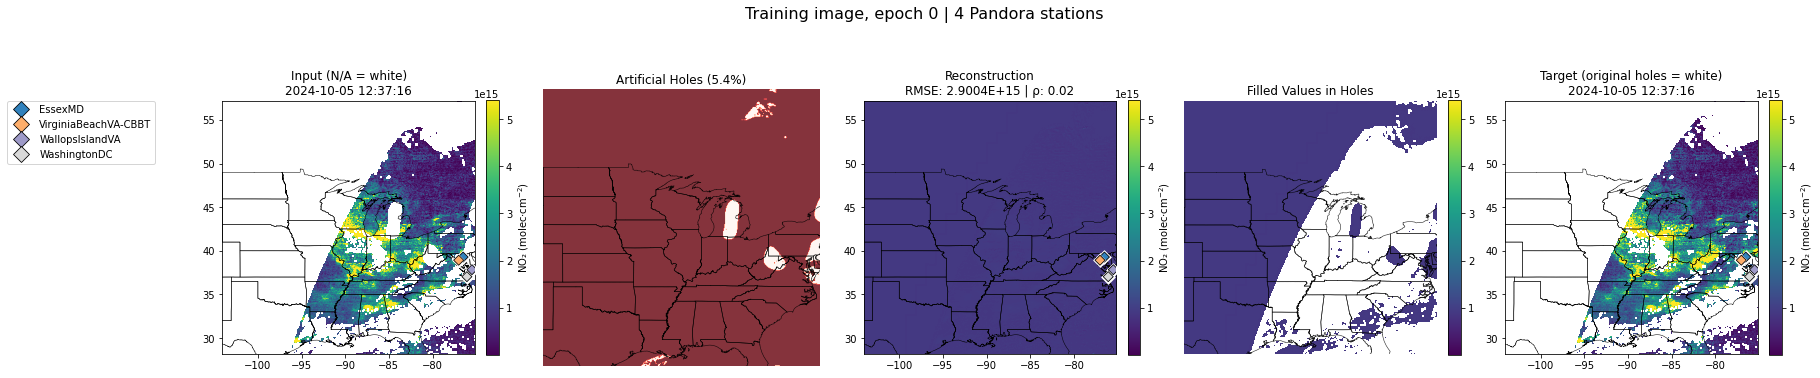

Pandora RMSE: 2.7273E+15 (4 stations)
Pandora correlation (ρ): -0.400


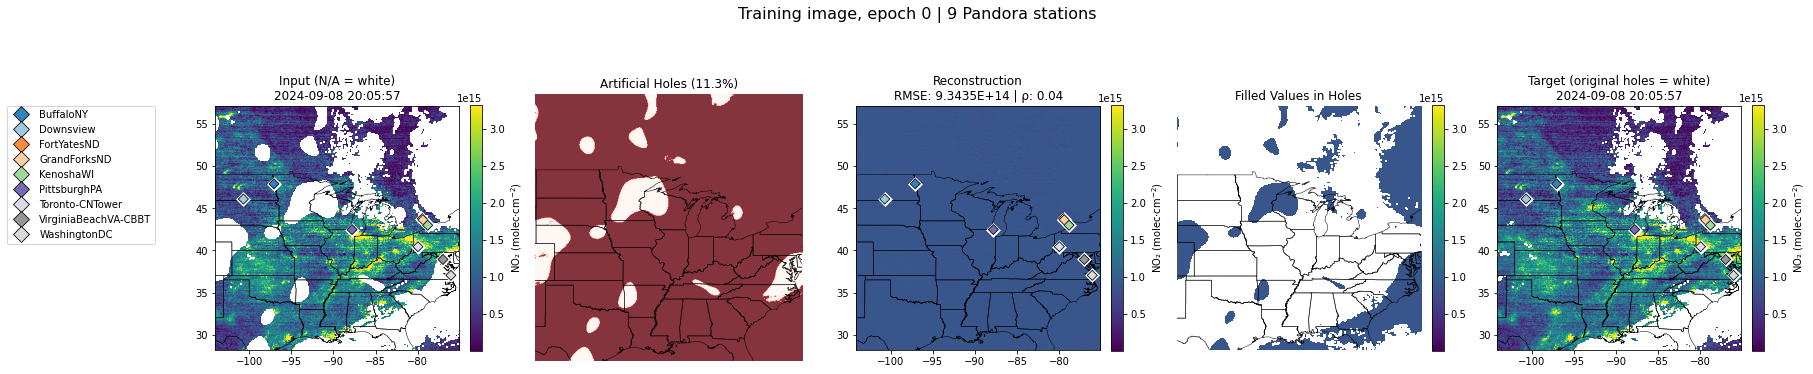

Pandora RMSE: 5.3970E+14 (9 stations)
Pandora correlation (ρ): -0.017


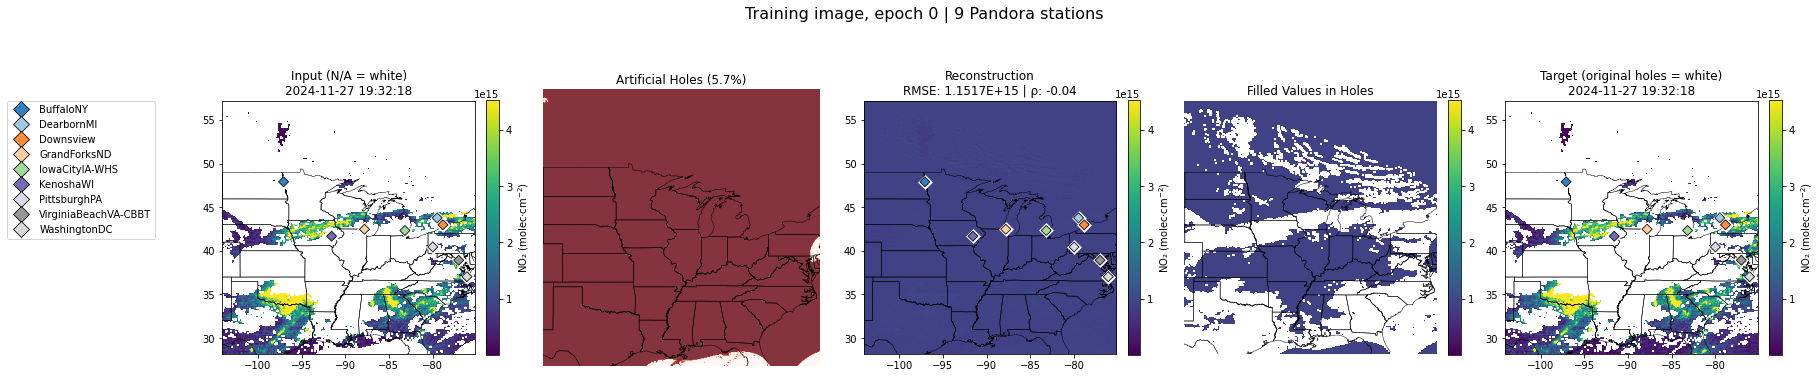

Pandora RMSE: 6.4930E+15 (9 stations)
Pandora correlation (ρ): -0.433


KeyboardInterrupt: 

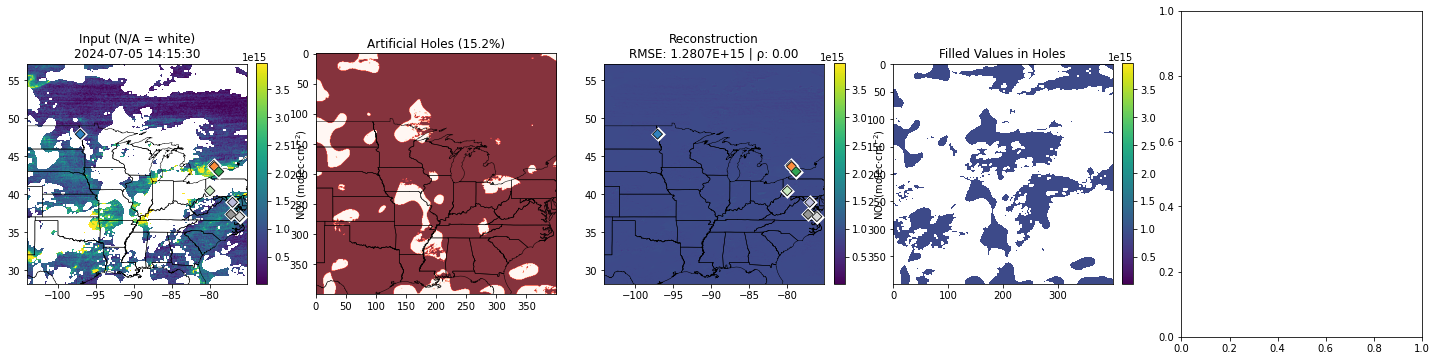

In [29]:
def train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=200, patience=5):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    best_loss = float("inf")
    best_state = None
    wait = 0
    history = []
    
    for epoch in range(epochs):
        train_loader.dataset.current_epoch = epoch
        train_loader.dataset.max_epochs = epochs
        
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,'n_pandora_stations': 0}
        train_batch_count = 0
        
        for batch in train_loader:
            img = batch["masked_img"].cuda()
            mask = batch["known_and_fake_mask"].cuda()
            mask_aug = batch["fake_mask"].cuda()
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch["p_mask"]
            p_val_map = batch["p_val_mask"]

            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            # ----------------------------
            # Forward generator (UNet)
            # ----------------------------
            pred_t, _ = model(img, mask_aug)

            hole_mask = (mask == 0).float()
            pred_holes   = pred_t * hole_mask
            target_holes = target * hole_mask

            # ----------------------------
            # Train Discriminator
            # ----------------------------
            d_real = D(target_holes.detach())   # Real holes → detach so G isn't updated
            d_fake = D(pred_holes.detach())     # Fake holes → also detach
            loss_D = d_loss(d_real, d_fake)
            
            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # ----------------------------
            # Train Generator (UNet)
            # ----------------------------
            # Run D again on pred_holes without detach so G can backprop
            d_fake_for_G = D(pred_holes)
            loss_G_adv = g_adv_loss(d_fake_for_G)

            # Your reconstruction + texture-aware progressive loss
            loss_recon = improved_loss_progress(pred_t, target, mask, epoch, epochs,  d_fake=d_fake_for_G)   # use the non-detached version here)

            

            # Combine generator losses

            opt.zero_grad()
            loss_recon.backward()
            opt.step()

            train_loss += loss_recon.item()

        
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug, known_mask, 
                                              p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            train_batch_count += 1
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=False, train=True, shp_path=shp_path)
            
        
            
        for key in train_metrics:
            train_metrics[key] /= train_batch_count
        train_loss /= len(train_loader)

        # ---- Validation (Simple Version) ----
        model.eval()
        val_loader.dataset.current_epoch=0
        val_loader.dataset.max_epochs =1
        val_loss = 0
        val_metrics = {
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        val_batch_count = 0

        with torch.no_grad():
            for batch in (val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch["p_mask"]
                p_val_map = batch["p_val_mask"]

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None

                pred, _ = model(img, mask)
                loss = improved_loss_progress(pred, target, mask, epoch, epochs, d_fake=None)
                val_loss += loss.item()

                # Calculate metrics for first sample in batch only (faster)
                batch_metrics = calculate_metrics(
                    pred, target, mask, mask,  # Use known_mask for both
                    p_mask=p_mask, p_values=p_val_map, normalizer=normalizer,
                )

                # Add to validation totals
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key]

                val_batch_count += 1


        # Average validation metrics and loss over all batches
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= val_batch_count

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"\tTrain metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"\tTrain Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
                  
        if val_metrics['n_pandora_stations'] > 0:
            print(f"\tVal Pandora metrics - RMSE: {val_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {val_metrics['pandora_mae']:.4E}, "
                  f"ρ: {val_metrics['pandora_rho']:.2f}, "
                  f"R²: {val_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), f"pconvunet_{epoch}.pt")
#         else:
#             wait += 1
#             if wait >= patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break
                
        # Store all metrics in history
        epoch_data = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "train_pandora_rmse": train_metrics['pandora_rmse'],
            "train_pandora_mae": train_metrics['pandora_mae'],
            "train_pandora_rho": train_metrics['pandora_rho'],
            "train_pandora_r2": train_metrics['pandora_r2'],
            "train_n_pandora_stations": train_metrics['n_pandora_stations'],
            "val_pandora_rmse": val_metrics['pandora_rmse'],
            "val_pandora_mae": val_metrics['pandora_mae'],
            "val_pandora_rho": val_metrics['pandora_rho'],
            "val_pandora_r2": val_metrics['pandora_r2'],
            "val_n_pandora_stations": val_metrics['n_pandora_stations'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        }
        history.append(epoch_data)
        
        if epoch % 10 == 0: 
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=train_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=True, shp_path=shp_path)
            
            visualize_batch(epoch=epoch, model=model, normalizer=normalizer, dataloader=val_loader,
                    batch_idx=0, sample_idx=0, device="cuda", save=True, train=False, shp_path=shp_path)
        
        # Write all metrics to CSV
        fieldnames = [
            "epoch", "train_loss", "val_loss", 
            "train_rmse", "train_mae", "train_r2",
            "train_pandora_rmse", "train_pandora_mae", "train_pandora_rho", "train_pandora_r2", "train_n_pandora_stations",
            "val_pandora_rmse", "val_pandora_mae", "val_pandora_rho", "val_pandora_r2", "val_n_pandora_stations",
            "pred_min_range", "pred_max_range"
        ]
        
        with open('csv_history.csv', "w", newline="") as f:
            csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
            csv_writer.writeheader()
            csv_writer.writerows(history)
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model
import torchvision.transforms.functional as TF

model = OriginalPlusMinimalAttentionDeep(base_ch=32).cuda()  # Your original + tiny attention
model = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=150, patience=20)